Copyright Preferred Computational Chemistry, Inc as contributors to Matlantis contrib project

# ヒルデブラント溶解度パラメータの計算

本ノートブックでは7つの有機分子に関するヒルデブラント溶解度パラメータの計算を行います。

**重要**\
本ノートブックを実行する前に、matlantis-lammpsパッケージをインストールしてください。

In [1]:
import subprocess
import os
import shutil
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

In [15]:
# シミュレーションを実行するターゲット化合物名の指定
compounds = [
    "1_Ethylchrolide", 
    "2_n-Butanol", 
    "3_THF", 
    "4_Neopentane", 
    "5_Toluene", 
    "6_Hexane", 
    "7_Methylmetacrylate"
]

# ターゲット化合物名の分子量
molweight = [
    64.51, 
    74.12,
    72.11,
    72.15,
    92.14,
    86.18,
    100.12
] 

# liquid、vaporそれぞれにターゲット化合物の初期構造を入れておく
directories = ["liquid", "vapor"]

# 原子質量の定義
mass_data = {"H" : 1.008, "C" : 12.011, "O" : 15.999, "Cl" : 35.450}

In [16]:
# LAMMPSインプットファイルの調整
def extract_atom_types(data_file_path, mass_data):
    atom_types = []
    with open(data_file_path, 'r') as file:
        lines = file.readlines()
        start = False
        for line in lines:
            if "Masses" in line:
                start = True
            elif "Atoms" in line:
                break
            elif start and line.strip():
                mass = float(line.split()[1])
                # 与えられた質量に最も近い原子種を見つける
                closest_atom_type = min(mass_data, key=lambda k: abs(mass_data[k] - mass))
                atom_types.append(closest_atom_type)
    return atom_types

def add_atom_types_to_lammps_input(input_file, atom_types):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    with open(input_file, 'w') as file:
        for line in lines:
            if line.startswith('pair_coeff * * species'):
                line = line.strip() + ' ' + ' '.join(atom_types) + '\n'
            file.write(line)

def comment_out_lines(original_file, modified_file, start_strings):
    with open(original_file, 'r') as file:
        lines = file.readlines()

    with open(modified_file, 'w') as file:
        for line in lines:
            if any(line.startswith(s) for s in start_strings):
                file.write(f"#{line}")
            else:
                file.write(line)

def modify_lammps_input(file_path, data_file_relative_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    with open(file_path, 'w') as file:
        for line in lines:
            if line.startswith('read_data'):
                file.write(f"read_data {data_file_relative_path}\n")
                print(data_file_relative_path)
            else:
                file.write(line)

In [17]:
# LAMMPSの計算を順番に実行するための準備
def run_lammps_for_compound(compound, directories):
    data_file_name = f"{compound}.data"
    estimator = Estimator()
    model_names = tuple(estimator.available_models)

    for directory in directories:
        compound_dir = os.path.join(directory, compound)
        data_file_relative_path = os.path.join("..", "init_data", data_file_name)
        data_file_path = os.path.join(directory, "init_data", data_file_name)
        atom_types = extract_atom_types(data_file_path, mass_data)
        
        # 化合物のディレクトリを作成
        if not os.path.exists(compound_dir):
            os.makedirs(compound_dir)            
            
        # 全てのLAMMPS入力ファイルを新しいディレクトリにコピー
        steps = ["1_min.lammps", "2_nvt.lammps", "3_npt.lammps"]
        for step in steps:
            original_file = os.path.join(directory, step)
            if os.path.exists(original_file):
                destination_file = os.path.join(compound_dir, step)
                shutil.copy(original_file, destination_file)
                
                # Massesセクションの原子種を抽出
                add_atom_types_to_lammps_input(destination_file, atom_types)

                if step == "1_min.lammps":
                    modify_lammps_input(destination_file, data_file_relative_path)

        # 元のディレクトリを記録
        original_dir = os.getcwd()

        # カレントディレクトリを変更
        os.chdir(compound_dir)

        # 各ステップのLAMMPS計算を実行
        for step in steps:
            if os.path.exists(step):
                print(f" ")
                print(f"##########################################################################")
                print(f"Running LAMMPS for {step} in {directory} : {compound}...")
                print(f"##########################################################################")
                print(f" ")
                subprocess.run(["lmp_serial", "-in", step])
                print(f"Completed: {step}")

                # ステップ名からファイル名の一部を抽出
                step_name = step.split('.')[0].split('_')[1]
                final_file = f"lmp_{step_name}_final.data"
                modified_file = f"lmp_{step_name}_final_mod.data"

                if os.path.exists(final_file):
                    comment_out_lines(final_file, modified_file, ["Pair Coeffs"] + list(model_names))

        # カレントディレクトリを元に戻す
        os.chdir(original_dir)

In [18]:
# LAMMPSの計算を各化合物毎に連続実行
for compound in compounds:
    run_lammps_for_compound(compound, directories)

../init_data/1_Ethylchrolide.data
 
##########################################################################
Running LAMMPS for 1_min.lammps in input/liquid : 1_Ethylchrolide...
##########################################################################
 
LAMMPS (29 Sep 2021 - Update 1)
Reading data file ...
  orthogonal box = (-9.8527450 -9.8527450 -9.8527450) to (9.8527450 9.8527450 9.8527450)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  400 atoms
  read_data CPU = 0.001 seconds
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.01
  ghost atom cutoff = 2.01
  binsize = 1.005, bins = 20 20 20
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair pfp_api, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style    : metal
  Current step  

In [6]:
# 平均値を計算するデータの割合を設定
AVERAGE_DATA_PERCENTAGE = 0.2  # 最後から20%をサンプリング

# MDシミュレーションセル中の分子数
MOL = 50

# SP実験値は、
# compounds = ["1_Ethylchrolide", "2_n-Butanol", "3_THF", "4_Neopentane", "5_Toluene", "6_Hexane", "7_Methylmetacrylate"]
# の順に対応
SP_exp = [9.2, 11.3, 9.1, 6.3, 9.0, 7.3, 8.8]

In [7]:
# LAMMPSで出力されたenergy_*を読み取り、ポテンシャルエネルギーと密度を集計
def calculate_average_energy_and_density(file_path, percentage=AVERAGE_DATA_PERCENTAGE):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # コメント行を除外し、データを読み込む
    data = np.array([line.split() for line in lines if not line.startswith('#')], dtype=float)

    # 最後の指定された割合のデータの平均を計算
    if len(data) > 0:
        start_index = int(len(data) * (1 - percentage))
        average_energy = np.mean(data[start_index:, 1])

        # 密度のデータがある場合、その平均も計算
        if data.shape[1] > 2:
            average_density = np.mean(data[start_index:, 2])
            return average_energy, average_density
        else:
            return average_energy, None
    else:
        return None, None

In [8]:
# 各化合物に対してポテンシャルエネルギー、密度、分子量からSP値を計算
results = []
for compound, mw, sp_exp in zip(compounds, molweight, SP_exp):
    averaged_energy_for_liquid = 0.0
    averaged_density_for_liquid = 0.0
    averaged_energy_for_vapor = 0.0
    for directory in directories:
        compound_dir = os.path.join(directory, compound)
        if os.path.exists(compound_dir):
            energy_files = [f for f in os.listdir(compound_dir) if f.startswith("energy_")]

            for file in energy_files:
                file_path = os.path.join(compound_dir, file)
                average_energy, average_density = calculate_average_energy_and_density(file_path)
                if average_density is not None:
                    averaged_energy_for_liquid = average_energy
                    averaged_density_for_liquid = average_density
                else:
                    averaged_energy_for_vapor = average_energy
                    
    # dE=Ev-El [kcal/mol]
    dE = (averaged_energy_for_vapor - (averaged_energy_for_liquid) / MOL) * 23.0605478306  # eV to kcal/mol 
    
    # MolarVolume
    MolVol = mw / averaged_density_for_liquid
    
    # SP値算出と表示
    SP_calc = math.sqrt((dE * 1000) / MolVol)
    results.append({
        "Compounds": compound,
        "SP calc. [cal cm-3^(1/2)]": SP_calc,
        "SP exp. [cal cm-3^(1/2)]": sp_exp,
        })

In [9]:
# 結果一覧
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(results)
df

,Compounds,SP calc. [cal cm-3^(1/2)],SP exp. [cal cm-3^(1/2)]
0,1_Ethylchrolide,8.97,9.20
1,2_n-Butanol,12.21,11.30
2,3_THF,9.72,9.10
3,4_Neopentane,7.27,6.30
4,5_Toluene,9.72,9.00
5,6_Hexane,8.76,7.30
6,7_Methylmetacrylate,8.08,8.80


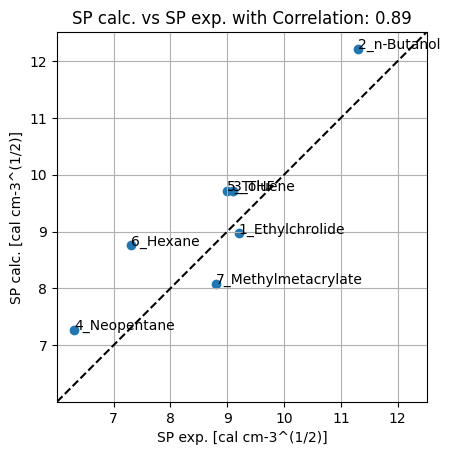

In [10]:
# 散布図による結果の表示

# 縦軸計算値、横軸実験値
sp_calc = df['SP calc. [cal cm-3^(1/2)]'].tolist()
sp_exp = df['SP exp. [cal cm-3^(1/2)]'].tolist()

# 相関係数の計算
correlation = np.corrcoef(sp_calc, sp_exp)[0, 1]

# 散布図の描画
plt.scatter(df["SP exp. [cal cm-3^(1/2)]"], df["SP calc. [cal cm-3^(1/2)]"])
plt.axis('square')
plt.xlabel("SP exp. [cal cm-3^(1/2)]")
plt.ylabel("SP calc. [cal cm-3^(1/2)]")
plt.title("SP calc. vs SP exp.")
plt.title(f"SP calc. vs SP exp. with Correlation: {correlation:.2f}")
plt.grid(True)

# x軸とy軸の範囲を同じにする
min_val = min(min(sp_calc), min(sp_exp))
max_val = max(max(sp_calc), max(sp_exp))
range_extension = (max_val - min_val) * 0.05  # 5%の範囲拡張
plt.xlim(min_val - range_extension, max_val + range_extension)
plt.ylim(min_val - range_extension, max_val + range_extension)

# 対角線を描画
plt.plot([min_val - range_extension, max_val + range_extension], [min_val - range_extension, max_val + range_extension], 'k--')

# 各点に化合物の名前を表示
for i, compound in enumerate(df["Compounds"]):
    plt.text(df["SP exp. [cal cm-3^(1/2)]"][i], df["SP calc. [cal cm-3^(1/2)]"][i], compound)

plt.show()